In [1]:
#install kaggle to upload kaggle's dataset
!pip install kaggle

In [3]:
#looking for a datasaet
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets list -s anime-face

ref                                                     title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
splcher/animefacedataset                                Anime Face Dataset                               395MB  2019-10-13 16:33:20          21347        316  0.9375           
soumikrakshit/anime-faces                               Anime Faces                                      441MB  2019-05-16 10:38:47           9570        187  0.625            
scribbless/another-anime-face-dataset                   another anime face dataset                         1GB  2021-04-24 12:42:57           2062         50  0.8125           
subinium/highresolution-anime-face-dataset-512x512      High-Resolution Anime Face Dataset (512x512)      15GB  202

In [4]:
#downloading the dataset
!kaggle datasets download -d splcher/animefacedataset

100% 394M/395M [00:05<00:00, 42.5MB/s]
100% 395M/395M [00:05<00:00, 70.2MB/s]


In [5]:
#mooving dataset to a dir
!mkdir Dataset
!cp /content/animefacedataset.zip /content/Dataset/animefacedataset.zip
!unzip -q /content/Dataset/animefacedataset.zip -d /content/Dataset
!rm /content/Dataset/animefacedataset.zip

In [8]:
import os
import cv2

import torch; torch.manual_seed(145)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from PIL import Image


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [96]:
#making a custom dataset to change img to a needed format
class IMG_dataset(torch.utils.data.Dataset):
    def __init__(self, path_dir:str):
        super().__init__()
        self.path_dir = path_dir
        self.dir_list = sorted([f for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]) #get filenames in a path dir
        self.dir_list = self.dir_list

        # self.dir_list = self.dir_list[:10000] #take only fist 10000 img


    def __len__(self):
        return len(self.dir_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path_dir, self.dir_list[idx])
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load image as RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = img.astype(np.float32) / 255.0    #normalizing images
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_LINEAR) #set size to img
        img = img.transpose((2, 0, 1))
        t_img = torch.from_numpy(img) #making a pytorch tensor from numpy array

        return t_img

In [97]:
train_face_path = "/content/Dataset/images" #path to the folder with img
train_face = IMG_dataset(train_face_path)

In [98]:
#making a dataloader
batch_size = 4

train_loader = torch.utils.data.DataLoader(
    train_face, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=True
)


In [99]:
#check if the loader works and check img size
for img in train_loader:
  print(img.shape)
  break

torch.Size([4, 3, 64, 64])


In [156]:
#making the encoder architecture
class Encoder(nn.Module):
  def __init__(self, input_channels=3, hidden_dims=64):
    super(Encoder, self).__init__()
    self.act = nn.ReLU()
    self.maxpool = nn.MaxPool2d(2, 2)

    self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

    self.linear1 = nn.Linear(8192, 128*4)
    self.linear2 = nn.Linear(128*4, 128*2)
    self.linear4mu = nn.Linear(128*2, hidden_dims)
    self.linear4sigma = nn.Linear(128*2, hidden_dims)

    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
    self.N.scale = self.N.scale.cuda()
    self.kl = 0

  def forward(self, x):
    x = self.act(self.conv1(x))
    x = self.maxpool(x)
    x = self.act(self.conv2(x))
    x = self.maxpool(x)
    x = self.act(self.conv3(x))
    x = self.maxpool(x)

    x = x.view(x.size(0), -1)

    x = self.act(self.linear1(x))
    x = self.act(self.linear2(x))

    mu = self.linear4mu(x)
    sigma = torch.exp(self.linear4sigma(x))
    z = mu + sigma*self.N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #calculate kl divergense
    return z

In [157]:
#making a decoder class
class Decoder(nn.Module):
  def __init__(self, output_channels=3, hidden_dims=64):
    super(Decoder, self).__init__()
    self.act = nn.ReLU()
    self.linear1 = nn.Linear(hidden_dims, 128*2)
    self.linear2 = nn.Linear(128*2, 128*4)
    self.linear3 = nn.Linear(128*4, 8192)

    self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
    self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
    self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)

  def forward(self, z):
    x = self.act(self.linear1(z))
    x = self.act(self.linear2(x))
    x = self.act(self.linear3(x))
    x = x.view(4, 128, 8, 8)
    x = self.act(self.deconv1(x))
    x = self.act(self.deconv2(x))
    reconstructed_images = torch.sigmoid(self.deconv3(x))

    return reconstructed_images.reshape((4, 3, 64, 64))

In [158]:
#combine the encoder and the decoder classes into a vae
class VAE(nn.Module):
  def __init__(self, output_channels=3, hidden_dims=64):
    super(VAE, self).__init__()
    self.encoder = Encoder(output_channels, hidden_dims)
    self.decoder = Decoder(output_channels, hidden_dims)

  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

In [159]:
#train the vae
def train(autoencoder, data, epochs=12):
    opt = torch.optim.Adam(autoencoder.parameters()) #set optimizer - Adam
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0

        # Create a progress bar for the current epoch
        progress_bar = tqdm(data, desc=f"Epoch {epoch}/{epochs}", unit="batch")

        for x in progress_bar:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat) ** 2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()

            total_loss += loss.item()
            num_batches += 1

            # Update the progress bar with the current loss
            progress_bar.set_postfix(loss=total_loss / num_batches)

        # Print the average loss for the epoch
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch}/{epochs}, Average Loss: {avg_loss:.4f}")

    return autoencoder

In [160]:
hidden_dims = 128
output_chanels = 3
data = train_loader
num_epochs = 4

In [161]:
#info
pytorch_total_params = sum(p.numel() for p in VAE().parameters() if p.requires_grad)
pytorch_total_params

8968483

In [162]:
#initializing vae
vae = VAE(output_chanels, hidden_dims).to(device)
vae = train(vae, data, num_epochs)

Epoch 0/4: 100%|██████████| 15891/15891 [03:30<00:00, 75.35batch/s, loss=2.15e+3]


Epoch 0/4, Average Loss: 2152.3308


Epoch 1/4: 100%|██████████| 15891/15891 [03:29<00:00, 75.84batch/s, loss=1.89e+3]


Epoch 1/4, Average Loss: 1887.7181


Epoch 2/4: 100%|██████████| 15891/15891 [03:29<00:00, 75.80batch/s, loss=1.82e+3]


Epoch 2/4, Average Loss: 1818.7203


Epoch 3/4: 100%|██████████| 15891/15891 [03:38<00:00, 72.84batch/s, loss=1.77e+3]

Epoch 3/4, Average Loss: 1770.7353


In [163]:
# Save the model
torch.save(vae.state_dict(), "my_model.pth")

In [ ]:
#loading a vae model if needed
model_path = '/kaggle/input/vaemaking/my_vae.pth'
# Load the model and map it to the CPU.
loaded_state_dict = torch.load(model_path)

#making a vae instanse to apply weights
vae = VAE()
#applying weights
vae.load_state_dict(loaded_state_dict)

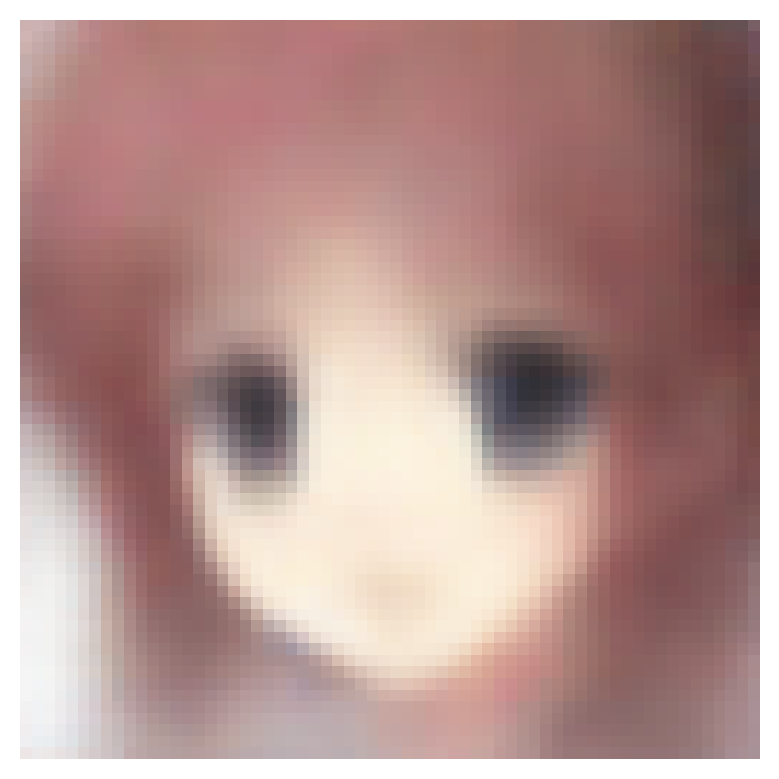

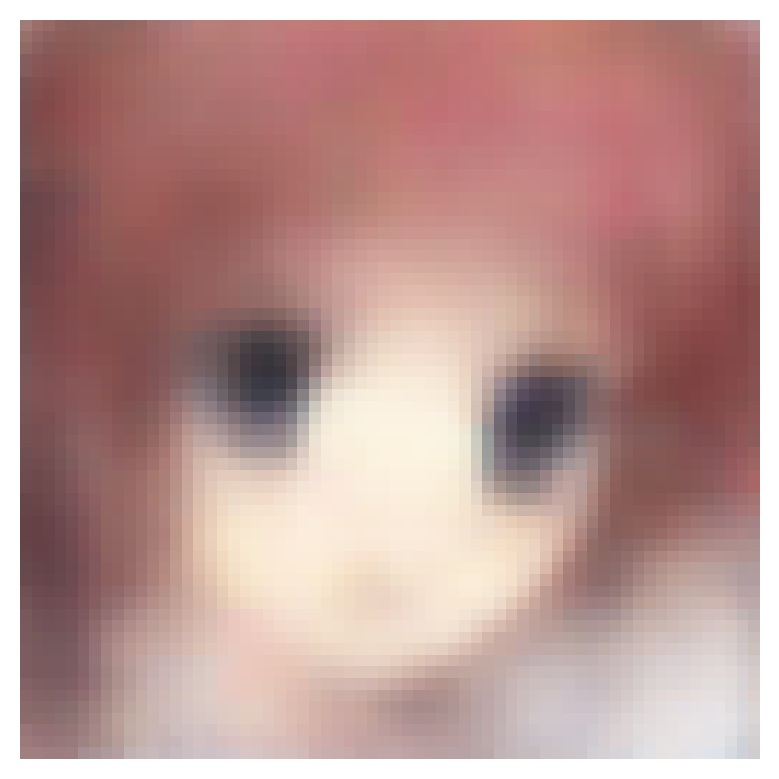

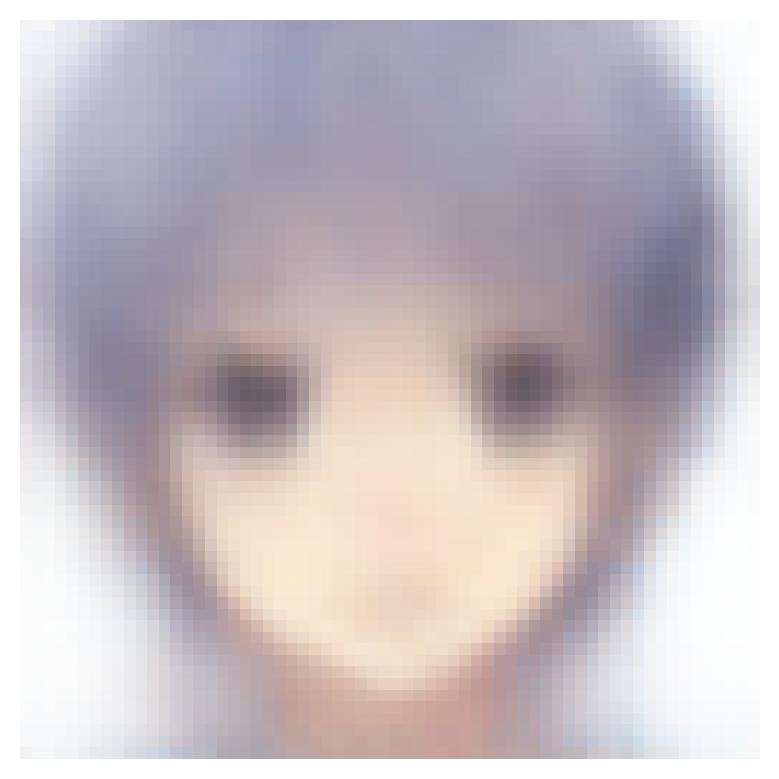

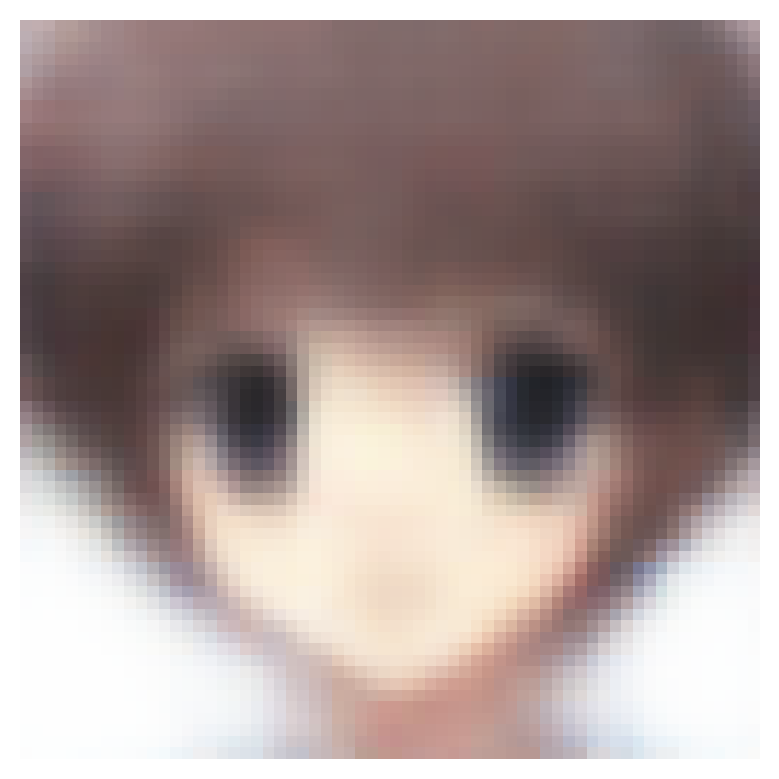

In [166]:
## GENERATING AN IMG

#generating a sample from normal distribution to generate a picture
batch_size = 4
z = vae.encoder.N.sample((batch_size, hidden_dims))


#getting decoder's output for a z
with torch.no_grad():
    if torch.cuda.is_available():
        z = z.cuda()
        vae.decoder = vae.decoder.cuda()
    reconstructed_image = vae.decoder(z)


# Convert the tensor to a NumPy array
image_np = reconstructed_image.squeeze(0).cpu().numpy()

#the image is in range [0, 1], rescale it to [0, 255] for visualization
image_np = (image_np * 255).astype(int)

i=0
for pic in range(4):
  # Plot the image using matplotlib
  plt.imshow(image_np[pic].transpose(1, 2, 0))
  plt.axis('off')  # Remove axis ticks and labels
  output_path = f'generated_image_{i}_third_gen.jpg'

  plt.savefig(output_path) # save generated img

  plt.show() #plot generated img
  i+=1